<a href="https://colab.research.google.com/github/ngoctran1910/WSNs/blob/master/nsga2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

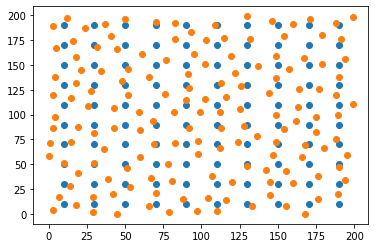

150
***********
[]
[ 71.  31.   4.  42.  84. 116.  46.  28.  63.  22. 101.  62.  65. 114.
  82.  99.  53. 142. 131. 143.  87. 140.  12.  30.  69.  59. 109. 146.
  67.  39.]
[143.  87. 140.  12.  30.  62.  69.  59. 109. 146.  67.  39.  71.  31.
   4.  42.  84. 116.  46.  28.  63.  22. 101.  65. 114.  82.  99.  53.
 142. 131.]
***********
[]
[143.  87. 140.  12.  30.  62.  69.  59. 109. 146.  67.  39.  71.  31.
   4.  42.  84. 116.  46.  28.  63.  22. 101.  65. 114.  82.  99.  53.
 142. 131.]
[ 71.  31.   4.  42.  84. 116.  46.  28.  63.  22. 101.  62.  65. 114.
  82.  99.  53. 142. 131. 143.  87. 140.  12.  30.  69.  59. 109. 146.
  67.  39.]
***********
[140.0, 5.0, 143.0, 123.0]
[  9. 126.  49.   1.  87. 139. 109.  57. 105. 148.  33. 140.   5.  95.
 143.  97. 108. 149. 124. 119. 131.   3.  20.  37. 144.  96.  22. 123.
 116.  88.]
[ 97. 108. 149. 124.  49. 119. 131.   3.  20.  37. 144.  96.  22.   7.
 116.  88.  38.   9. 126.   1.  87. 139. 109.  57. 105. 148.  33.  39.
 102.  95.]
***

In [25]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import json

data = json.load( open( "data5.json" ) )

#Constants
AREA_SIZE = [200, 200]
GRID_SIZE = [20, 20]
TARGET_POSITIONS = len(data["target_position"])
POPULATION_SIZE = 50
INDIVIDUAL_SIZE = len(data["potential_position"]) #number of potential locations
NUMBER_OF_SENSORS = 30
SINK_LOCATION = [100, 100]
GEN_MAX = 300

COMMUNICATION_RANGE = 50
SENSING_RANGE = 25
DESIRED_CONNECTIVITY = 4
DESIRED_COVERAGE = 2

potentialPos = np.array(data["potential_position"])
targetPos = np.array(data["target_position"])
#print(targetPos.shape)
x, y = targetPos.T
x1, y1 = potentialPos.T
plt.scatter(x, y)
plt.scatter(x1, y1)
plt.show()
print(len(potentialPos))

targetToPotential = np.zeros((INDIVIDUAL_SIZE, TARGET_POSITIONS)) #cột i là khoảng cách từ target location i đến các điểm có thể đặt sensors
for i in range(potentialPos.shape[0]):
  for j in range(targetPos.shape[0]):
    temp = np.linalg.norm(potentialPos[i]-targetPos[j])
    targetToPotential[i][j] = temp if temp != 0 else 0.001 
# print(targetToPotential.shape)

potentialToPotential = np.zeros((INDIVIDUAL_SIZE, INDIVIDUAL_SIZE))
for i in range(INDIVIDUAL_SIZE):
  for j in range(INDIVIDUAL_SIZE):
    potentialToPotential[i][j] = np.linalg.norm(potentialPos[i]-potentialPos[j])
# print(potentialToPotential.shape)

def createPopulation(size = POPULATION_SIZE):
  population = np.zeros((POPULATION_SIZE, NUMBER_OF_SENSORS))
  for i in range(POPULATION_SIZE):
    population[i] = np.random.choice(INDIVIDUAL_SIZE, NUMBER_OF_SENSORS, replace=False)
  return population

def crossover(indi1, indi2):
  diff = [i for i in indi1 if i not in indi2]
  if len(diff) < 5:
    print("***********")
    print(diff)
    print(indi1)
    print(indi2)

  # crossoverPoint = random.randint(0, NUMBER_OF_SENSORS - 1)
  crossoverPoint = random.randint(NUMBER_OF_SENSORS//4, 3*NUMBER_OF_SENSORS//4)
  child = list(indi1[:crossoverPoint])
  index = [j for j in indi2 if j not in child]
  for i in range(NUMBER_OF_SENSORS - crossoverPoint):
    child.append(index[i])
  # child = sorted(child)
  
  return np.array(child)

def mutate(indi, mutationRate = 0.03):
  candidate = [i for i in list(range(INDIVIDUAL_SIZE)) if i not in indi.astype(int)]
  for i in range(NUMBER_OF_SENSORS):
    if random.random() < mutationRate:
      choice = random.choice(candidate)
      indi[i] = choice
      candidate.remove(choice)
  
  if len(list(indi)) != NUMBER_OF_SENSORS:
    print("============")
    print(indi)
  return indi

def find_rank(target, l):
  for idx, val in enumerate(l):
    if target in val:
      return idx

def tournament_selection(pop, rank, FV, front, size = 70):
  choosen = []
  res = []
  for _ in range(size):
    choosen = random.sample(range(len(pop)), 2)
    if rank[choosen[0]] < rank[choosen[1]]:
      res.append(pop[choosen[0]])
    else:
      if rank[choosen[0]] > rank[choosen[1]]:
        res.append(pop[choosen[1]])
      else:
        dist = crowding_distance(front[rank[choosen[0]]], FV)
        if dist[choosen[0]] > dist[choosen[1]]:
          res.append(pop[choosen[0]])
        else:
          if dist[choosen[0]] < dist[choosen[1]]:
            res.append(pop[choosen[1]])
          else:
            res.append(pop[random.choice(choosen)])
  return res

def computeCoverage(indi):
  cov = np.zeros((NUMBER_OF_SENSORS, TARGET_POSITIONS))
  res = 0
  for i in range(NUMBER_OF_SENSORS):
    cov[i] = targetToPotential[int(indi[i])]
  for j in range(TARGET_POSITIONS):
    y = cov[:, j]
    x = np.count_nonzero(y <= SENSING_RANGE)
    if(x >= DESIRED_COVERAGE):
      res = res + 1
    else:
      res = res + 1.0 * (x/(DESIRED_COVERAGE))
  return round(res/TARGET_POSITIONS, 2)

def computeConnectivity(indi):
  li = [i for i in list(range(INDIVIDUAL_SIZE)) if i not in indi]
#   con = np.zeros((NUMBER_OF_SENSORS, NUMBER_OF_SENSORS))
  con = np.delete(potentialToPotential, li, 1)
  con = np.delete(con, li, 0)
  res = 0
  for j in range(NUMBER_OF_SENSORS):
    x = np.count_nonzero(con[j] <= COMMUNICATION_RANGE) - 1
    if x >= DESIRED_CONNECTIVITY:
      res = res + 1
    else:
      res = res + 1.0 * (x/(DESIRED_CONNECTIVITY))
  return round(res/NUMBER_OF_SENSORS, 2)

def checkNonDominated(fv1, fv2): #check if fv2 dominated fv1
  if np.count_nonzero(fv1 <= fv2) == 2:
    if np.count_nonzero(fv1 < fv2) >= 1:
      return True
  return False

def nonDominateSort(pop, FV):
  # S=[[] for i in range(POPULATION_SIZE*2)]
  # front = [[]]
  # n=[0 for i in range(POPULATION_SIZE*2)]
  # rank = [0 for i in range(POPULATION_SIZE*2)]
  S=[[] for i in range(len(pop))]
  front = [[]]
  n=[0 for i in range(len(pop))]
  rank = [0 for i in range(len(pop))]
  
  for idx1, indi1 in enumerate(pop):
    # S[i] = []  #a set of solutions that the solution dominates
    # n[i] = 0  #the number of solutions which dominate the solution
    for idx2, indi2 in enumerate(pop):
      if checkNonDominated(FV[idx2], FV[idx1]) == True:
        S[idx1].append(idx2)
      else:
        if checkNonDominated(FV[idx1], FV[idx2]) == True:
          n[idx1] += 1
    if n[idx1] == 0:
      rank[idx1] = 0
      if idx1 not in front[0]:
        front[0].append(idx1)
  # for idx, val in enumerate(n):
  #   print(idx, val)

  i = 0
  while front[i]!=[]:
    Q = []
    for j in front[i]:
      for idx in S[j]:
        n[idx] -= 1
        if n[idx] == 0:
          rank[idx] = i+1
          if idx not in Q:
            Q.append(idx)
    i = i+1
    front.append(Q)
  del front[len(front) - 1]
  return front, rank

def crowding_distance(last_front, FV):
  distance = {}
  cov = []
  con = []
  for idx in last_front:
    cov.append(FV[idx, 0])
    con.append(FV[idx, 1])
    distance[idx] = 0
  
  max_cov = max(FV[:, 0])
  min_cov = min(FV[:, 0])
  max_con = max(FV[:, 1])
  min_con = min(FV[:, 1])

  sorted_last_front = sorted(zip(cov, last_front))
  distance[sorted_last_front[0][1]] = 1e15
  distance[sorted_last_front[len(last_front) - 1][1]] = 1e15
  # Z = [x for _,x in sorted(zip(FV[:, i], last_front))]
  if(max_cov!=min_cov):
    for j in range(1, len(last_front)-1):
      val = sorted_last_front[j][0]
      idx = sorted_last_front[j][1]
      # if(max(cov) - min(cov)) == 0:
      #   distance[idx] += (sorted_last_front[j+1][0] - sorted_last_front[j-1][0])/0.001
      # else:
      #   distance[idx] += (sorted_last_front[j+1][0] - sorted_last_front[j-1][0])/(max(cov) - min(cov))
      distance[idx] += (sorted_last_front[j+1][0] - sorted_last_front[j-1][0])/(max_cov - min_cov)

  sorted_last_front = sorted(zip(con, last_front))
  distance[sorted_last_front[0][1]] = 99999999
  distance[sorted_last_front[len(last_front) - 1][1]] = 99999999
  if(max_con!=min_con):
    for j in range(1, len(last_front)-1):
      val = sorted_last_front[j][0]
      idx = sorted_last_front[j][1]
      # if(max(con) - min(con)) == 0:
      #   distance[idx] += (sorted_last_front[j+1][0] - sorted_last_front[j-1][0])/0.001
      # else:
      #   distance[idx] += (sorted_last_front[j+1][0] - sorted_last_front[j-1][0])/(max(con) - min(con))
      distance[idx] += (sorted_last_front[j+1][0] - sorted_last_front[j-1][0])/(max_con - min_con)
  return distance

# dist = crowding_distance(f[0], FV)
# print(dist)

def mutatedPopulation(pop, mutationRate = 0.03):
  mutatedPop = []
  for indi in pop:
    mutatedIndi = mutate(indi.copy())
    # if list(mutatedIndi) != list(indi)
    mutatedPop.append(mutatedIndi)
  return mutatedPop
# b = mutatedPopulation(a)
# print(b)
def breedPopulation(pool):
  # pool = random.sample(matingPool, len(matingPool))
  breedPop = []
  for i in range(len(pool)):
    breedPop.append(crossover(pool[i], pool[len(pool)-1-i]))
  return breedPop

pop = createPopulation()
# for i in pop:
#   print(i)
front = [[]]
rank =[]
for gen in range(50):
  FV = np.zeros((len(pop), 2))
  for index in range(POPULATION_SIZE):
    FV[index] = [computeCoverage(pop[index]), computeConnectivity(pop[index])]
  front = [[]]
  rank =[]
  front, rank = nonDominateSort(pop, FV)
  # pool = tournament_selection(pop, rank, FV, front, size = 5)
  # pool = list(pop)
  # breed_pop = breedPopulation(pool)
  breed_pop = breedPopulation(list(pop))
  # print(breed_pop)
  for indi in breed_pop:
    mutate(indi)
  # mutated_pop = mutatedPopulation(breed_pop)
  pop = list(pop) + breed_pop 
  # print(len(pop))
  FV = np.zeros((len(pop), 2))
  for index in range(len(pop)):
    FV[index] = [computeCoverage(pop[index]), computeConnectivity(pop[index])]
    # print(pop[index], FV[index])

  front = [[]]
  rank = []
  front, rank = nonDominateSort(pop, FV)
  next_pop = []
  for i in range(len(front)):
    if (len(next_pop) + len(front[i])) <= POPULATION_SIZE:
      for j in front[i]:
        next_pop.append(pop[j])
    else:
      dist = crowding_distance(front[i], FV)
      sorted_d = sorted((value, key) for (key,value) in dist.items())
      current_pop_size = len(next_pop)
      for k in sorted_d:
        if current_pop_size < POPULATION_SIZE:
          next_pop.append(pop[k[1]])
          current_pop_size += 1
        else:
          break
      break
  pop = next_pop
  # print(len(pop))



In [2]:
cd /content/drive/My Drive/Colab Notebooks/data/data5

/content/drive/My Drive/Colab Notebooks/data/data5


In [26]:
print(len(front[0]))
print(rank)
count = 0
for i in rank:
  if i == 0:
    count = count +1
print(count)
# print(computeCoverage(pop[194]), computeConnectivity(pop[194]))
for i in range(50):
  print(computeCoverage(pop[i]), computeConnectivity(pop[i]))

6
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 5, 3, 2, 6, 1, 2, 2, 2, 5, 2, 6, 2, 6, 2, 2, 3, 3, 8, 8, 6, 9, 2, 7, 2, 2, 2, 4, 4, 4, 6, 1, 1, 5, 4, 1, 5, 1, 8, 1, 6, 1, 3, 4, 7, 8, 1, 5, 9, 0]
6
0.68 0.97
0.69 0.9
0.68 0.97
0.67 1.0
0.69 0.9
0.68 0.97
0.67 0.98
0.65 1.0
0.67 0.98
0.67 0.98
0.67 0.98
0.67 0.98
0.67 0.98
0.67 0.98
0.67 0.98
0.67 0.98
0.67 0.98
0.67 0.98
0.67 0.98
0.66 0.99
0.65 1.0
0.67 0.98
0.67 0.98
0.67 0.98
0.65 1.0
0.67 0.98
0.67 0.98
0.67 0.98
0.67 0.98
0.67 0.98
0.67 0.98
0.65 1.0
0.68 0.96
0.68 0.96
0.66 0.98
0.66 0.98
0.66 0.98
0.66 0.98
0.66 0.98
0.66 0.98
0.66 0.98
0.66 0.98
0.66 0.98
0.66 0.98
0.66 0.98
0.66 0.98
0.66 0.98
0.66 0.98
0.66 0.98
0.66 0.98
